In [37]:
import os
import numpy as np
from skimage import io, transform, measure

In [38]:
def load_segmentation_images(folder, size=(256,256)):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img = io.imread(os.path.join(folder, filename), as_gray=True)
            img_resized = transform.resize(img, size, anti_aliasing=True)
            img_bin = img_resized > 0.5
            images.append(img_bin)
            filenames.append(filename)
    return images, filenames

In [39]:
def extract_ring_pointset(image, num_points=200):
    contours = measure.find_contours(image, level=0.5)
    if len(contours) < 2:
        combined = contours[0]
    else:
        lengths = [len(c) for c in contours]
        outer = contours[np.argmax(lengths)]
        inner = contours[np.argmin(lengths)]
        combined = np.vstack([outer, inner])
    indices = np.linspace(0, len(combined)-1, num_points).astype(int)
    pts = combined[indices]
    return pts

In [40]:
def generate_pointsets(folder, size=(256,256), num_points=200):
    images, filenames = load_segmentation_images(folder, size=size)
    pointsets = [extract_ring_pointset(img, num_points=num_points) for img in images]
    return pointsets, filenames

In [41]:
seg_folder = '/mnt/c/users/ankku/downloads/assignmentShapeAnalysis/data/anatomicalSegmentations'  
pointsets, filenames = generate_pointsets(seg_folder, size=(256,256), num_points=200)

(b)

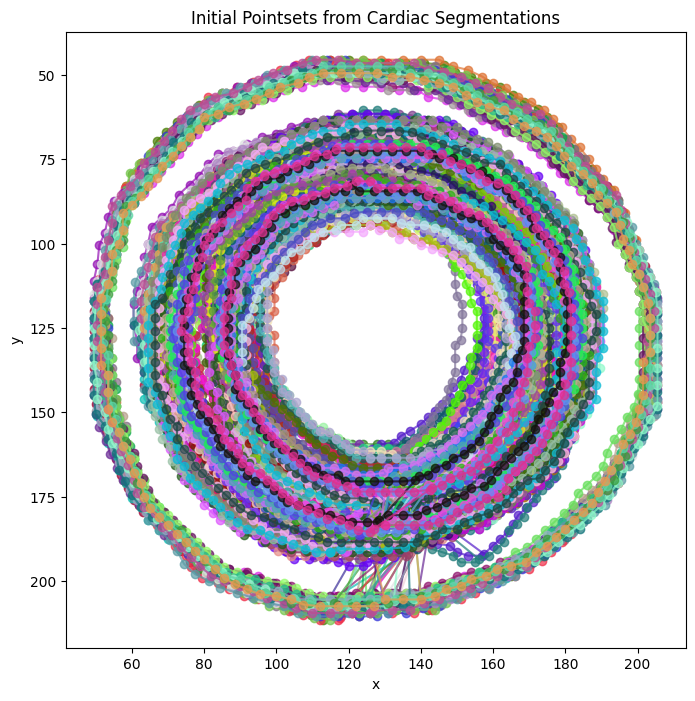

In [42]:
import matplotlib.pyplot as plt
import random

def plot_initial_pointsets(pointsets):
    plt.figure(figsize=(8,8))
    for pts in pointsets:
        color = np.random.rand(3,)
        plt.plot(pts[:,1], pts[:,0], 'o-', color=color, alpha=0.7)
    plt.gca().invert_yaxis()  
    plt.title("Initial Pointsets from Cardiac Segmentations")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

plot_initial_pointsets(pointsets)

(c)

In [7]:
def center_pointset(pts):
    return pts - np.mean(pts, axis=0)

In [8]:
def normalize_pointset(pts):
    norm = np.linalg.norm(pts, 'fro')
    return pts / norm if norm != 0 else pts

In [9]:
def to_preshape(pts):
    return normalize_pointset(center_pointset(pts))

In [ ]:
def align_by_rotation(X, Y):
    A = Y.T @ X
    U, _, Vt = np.linalg.svd(A)
    R = U @ Vt
    if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = U @ Vt
    Y_aligned = Y @ R
    return Y_aligned, R

In [ ]:
def compute_shape_mean_code11(shapes, max_iter=20, tol=1e-6):
    shapes_preshape = [to_preshape(shape) for shape in shapes]
    mean_shape = shapes_preshape[0]
    aligned_shapes = [None] * len(shapes_preshape)
    for _ in range(max_iter):
        for i, shape in enumerate(shapes_preshape):
            aligned, _ = align_by_rotation(mean_shape, shape)
            aligned_shapes[i] = aligned
        new_mean = np.mean(np.stack(aligned_shapes), axis=0)
        new_mean = normalize_pointset(new_mean)
        if np.linalg.norm(mean_shape - new_mean, 'fro') < tol:
            break
        mean_shape = new_mean
    return mean_shape, aligned_shapes

mean_code11, aligned_code11 = compute_shape_mean_code11(pointsets)

In [ ]:
def align_by_similarity(X, Y):
    mu_X = np.mean(X, axis=0)
    mu_Y = np.mean(Y, axis=0)
    Xc = X - mu_X
    Yc = Y - mu_Y
    norm_X = np.linalg.norm(Xc)
    norm_Y = np.linalg.norm(Yc)
    s = norm_X / norm_Y if norm_Y != 0 else 1.0
    Y_scaled = Yc * s
    A = Y_scaled.T @ Xc
    U, _, Vt = np.linalg.svd(A)
    R = U @ Vt
    if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = U @ Vt
    Y_aligned = (Yc @ R) * s + mu_X
    return Y_aligned, s, R, mu_X

In [ ]:
def compute_shape_mean_code22(shapes, max_iter=20, tol=1e-6):
    mean_shape = shapes[0]
    aligned_shapes = [None] * len(shapes)
    for _ in range(max_iter):
        for i, shape in enumerate(shapes):
            aligned, _, _, _ = align_by_similarity(mean_shape, shape)
            aligned_shapes[i] = aligned
        new_mean = np.mean(np.stack(aligned_shapes), axis=0)
        new_mean = center_pointset(new_mean)
        new_mean = normalize_pointset(new_mean)
        if np.linalg.norm(mean_shape - new_mean, 'fro') < tol:
            break
        mean_shape = new_mean
    return mean_shape, aligned_shapes

mean_code22, aligned_code22 = compute_shape_mean_code22(pointsets)

In [54]:
def plot_mean_and_aligned(mean_shape, aligned_shapes, title):
    plt.figure(figsize=(6,6))
    for pts in aligned_shapes:
        plt.plot(pts[:,1], pts[:,0], 'o-', alpha=0.3)
    plt.plot(mean_shape[:,1], mean_shape[:,0], 'r-', linewidth=2, label='Mean')
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.legend()
    plt.axis('equal')
    plt.show()

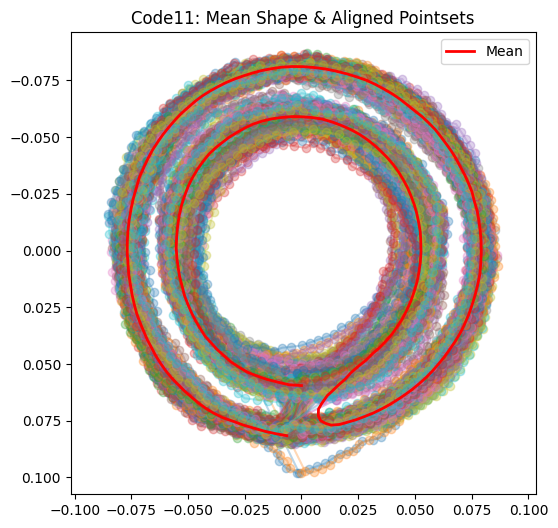

In [55]:
plot_mean_and_aligned(mean_code11, aligned_code11, "Code11: Mean Shape & Aligned Pointsets")

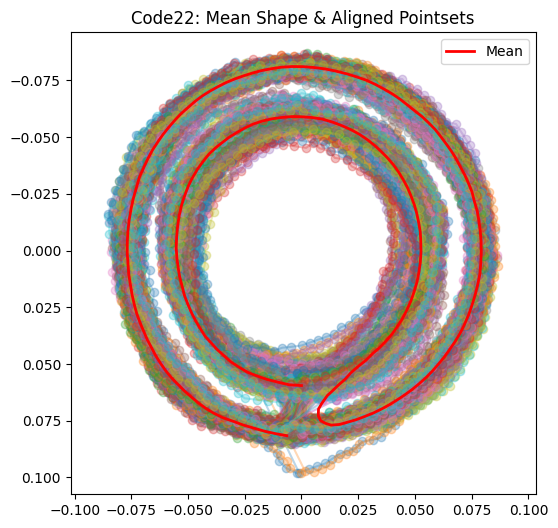

In [56]:
plot_mean_and_aligned(mean_code22, aligned_code22, "Code22: Mean Shape & Aligned Pointsets")

(d)

In [17]:
from sklearn.decomposition import PCA

def vectorize_pointset(pts):
    return pts.flatten()

In [18]:
def compute_pca(aligned_shapes):
    X = np.array([vectorize_pointset(pts) for pts in aligned_shapes])
    mean_vec = np.mean(X, axis=0)
    centered = X - mean_vec
    pca_model = PCA(n_components=10)
    pca_model.fit(centered)
    return pca_model

In [20]:
pca_code11 = compute_pca(aligned_code11)
pca_code22 = compute_pca(aligned_code22)

In [21]:
def plot_eigen_spectrum(pca_model, title):
    eigvals = pca_model.explained_variance_
    plt.figure(figsize=(6,4))
    plt.bar(range(1,4), eigvals[:3], color='skyblue')
    plt.title(title)
    plt.xlabel("Principal Mode")
    plt.ylabel("Variance (Eigenvalue)")
    plt.grid(True)
    plt.show()

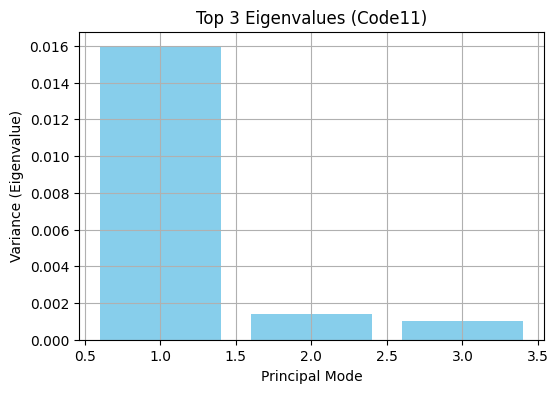

In [22]:
plot_eigen_spectrum(pca_code11, "Top 3 Eigenvalues (Code11)")

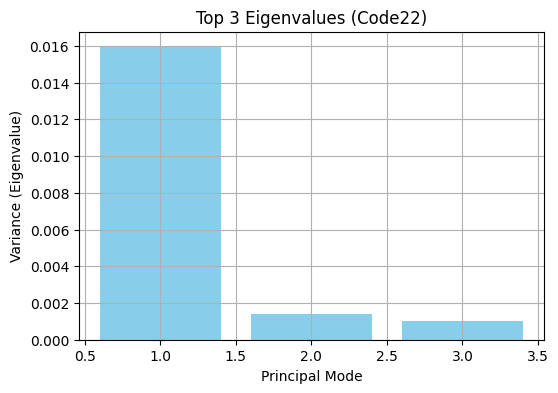

In [23]:
plot_eigen_spectrum(pca_code22, "Top 3 Eigenvalues (Code22)")

(e)

In [24]:
def compute_pca_with_modes(aligned_shapes):
    X = np.array([vectorize_pointset(pts) for pts in aligned_shapes])
    mean_vec = np.mean(X, axis=0)
    centered = X - mean_vec
    cov = np.cov(centered.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    return mean_vec, eigvals, eigvecs

In [25]:
def reconstruct_variation(mean_vec, eigvals, eigvecs, mode_index, std_multiplier=2):
    deviation = std_multiplier * np.sqrt(eigvals[mode_index])
    shape_plus = mean_vec + deviation * eigvecs[:, mode_index]
    shape_minus = mean_vec - deviation * eigvecs[:, mode_index]
    return shape_minus, shape_plus

In [66]:
def plot_variations(mean_vec, eigvals, eigvecs, aligned_shapes, title, k=2):
    num_points = len(mean_vec) // 2
    mean_shape = mean_vec.reshape((num_points,2))
    plt.figure(figsize=(12,8))
    
    plt.subplot(2,2,1)
    for pts in aligned_shapes:
        plt.plot(pts[:,1], pts[:,0], 'o-', alpha=0.4)
    plt.plot(mean_shape[:,1], mean_shape[:,0], 'r-', linewidth=2, label='Mean')
    plt.gca().invert_yaxis()
    plt.title(title + "\nAligned Shapes & Mean")
    plt.legend()
    plt.axis('equal')
    
    for i in range(3):
        minus, plus = reconstruct_variation(mean_vec, eigvals, eigvecs, i, std_multiplier=k)
        shape_minus = minus.reshape((num_points,2))
        shape_plus = plus.reshape((num_points,2))
        plt.subplot(2,3,i+4)
        plt.plot(mean_shape[:,1], mean_shape[:,0], 'r-', label='Mean')
        plt.plot(shape_minus[:,1], shape_minus[:,0], 'b--', label=f'-{k} SD')
        plt.plot(shape_plus[:,1], shape_plus[:,0], 'g--', label=f'+{k} SD')
        plt.gca().invert_yaxis()
        plt.title(f"Mode {i+1} Variation")
        plt.legend()
        plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [67]:
aligned_code11[0].shape

(200, 2)

In [68]:
mean_vec_11, eigvals_11_modes, eigvecs_11 = compute_pca_with_modes(aligned_code11)
mean_vec_22, eigvals_22_modes, eigvecs_22 = compute_pca_with_modes(aligned_code22)

/tmp/ipykernel_70428/1433200513.py:27: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


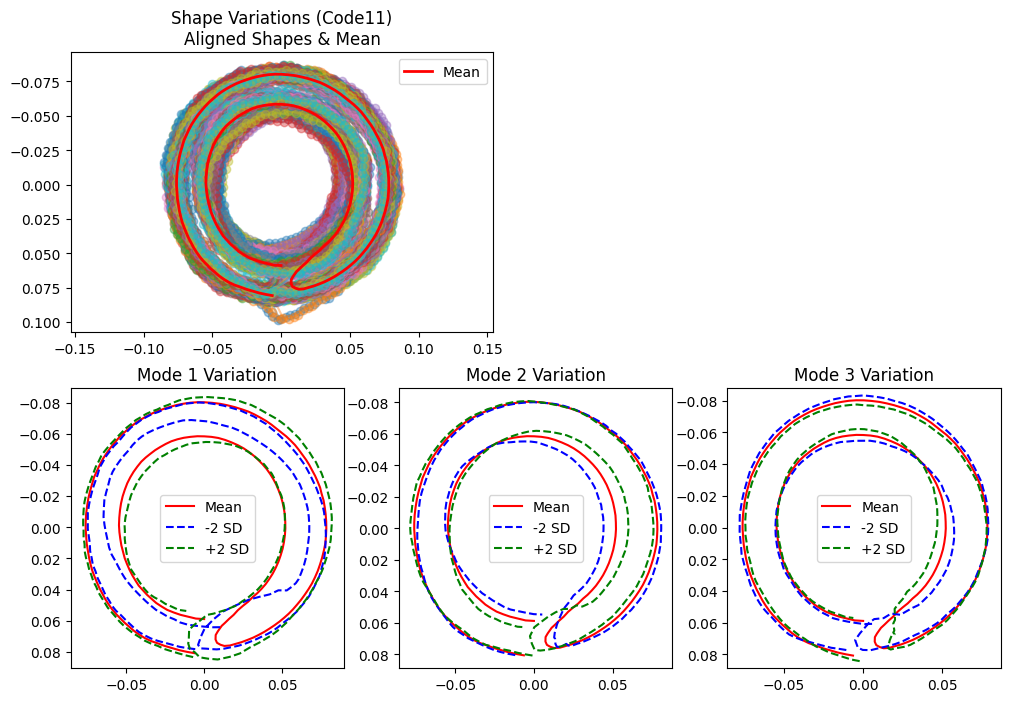

In [69]:
plot_variations(mean_vec_11, eigvals_11_modes, eigvecs_11, aligned_code11,
                "Shape Variations (Code11)", k=2)

/tmp/ipykernel_70428/1433200513.py:27: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


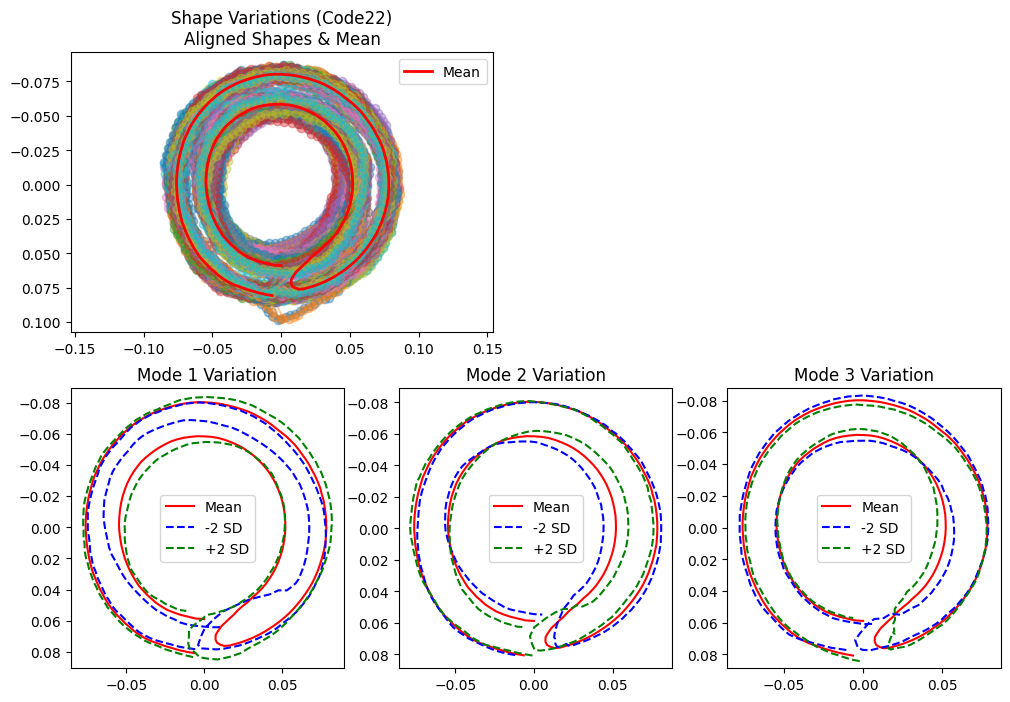

In [70]:
plot_variations(mean_vec_22, eigvals_22_modes, eigvecs_22, aligned_code22,
                "Shape Variations (Code22)", k=2)